In [ ]:
# Put this at the very top of your notebook
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt

# Ensure project root on sys.path for local imports when running directly
try:
    HERE = os.path.dirname(os.path.abspath(__file__))  # type: ignore[name-defined]
except NameError:
    HERE = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(HERE, ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from cls import WMEnv
from cls.utils.GridUtils import VectorHash
from cls.envs.environments import GridWMEnv
from cls.vectorhash.seq_utils import *
from cls.vectorhash.assoc_utils_np import *
from cls.vectorhash.senstranspose_utils import *
from  cls.vectorhash.assoc_utils_np_2D import gen_gbook_2d, path_integration_Wgg_2d, module_wise_NN_2d

seed = 3
rng = np.random.default_rng(seed)

In [ ]:
def setup_scaffold(Np, lambdas, thresh, c):
    Ng = np.sum(np.square(lambdas))
    Npos = np.prod(lambdas)
    gbook = gen_gbook_2d(lambdas, Ng, Npos)
    gbook.shape     # (Ng, Npos, Npos)

    module_sizes = np.square(lambdas)
    module_gbooks = [np.eye(i) for i in module_sizes]

    Wpg = randn(Np, Ng) 

    prune = int((1-c)*Np*Ng)
    mask = np.ones((Np, Ng))
    mask[randint(low=0, high=Np, size=prune), randint(low=0, high=Ng, size=prune)] = 0
    Wpg = np.multiply(mask, Wpg)
    
    pbook = nonlin(np.einsum('jk,klm->jlm', Wpg, gbook), thresh=thresh)  # (Np, Npos, Npos) 
    gbook_flattened = gbook.reshape(Ng, Npos*Npos)  #order='F'
    pbook_flattened = pbook.reshape(Np, Npos*Npos)

    Wgp = train_gcpc(pbook_flattened, gbook_flattened,Npatts=Npos*Npos)

    return pbook, pbook_flattened, gbook, gbook_flattened, Wpg, Wgp, module_sizes, module_gbooks, Npos, Ng

In [ ]:
def setup_envs(envs, size, n_envs, Npos, Ng, pbook, gbook):
    C_pairs = [(
        np.random.randint(size, Npos-size),
        np.random.randint(size, Npos-size)
    ) for _ in range(n_envs)]

    all_path_locations = []
    all_observations = []
    abook = []

    for env_idx, env in enumerate(envs):
        pos_obs_head = env.fully_explore()
        path_locations = np.array([poh[0] for poh in pos_obs_head]) # if poh[2] == (1, 0)])
        observations = np.array([poh[1] for poh in pos_obs_head]) # if poh[2] == (1, 0)])
        C_X, C_Y = C_pairs[env_idx]
        path_locations[:,0] = path_locations[:,0] + C_X
        path_locations[:,1] = path_locations[:,1] + C_Y

        all_path_locations.append(path_locations)
        all_observations.append(observations)

    all_path_locations = np.concatenate(all_path_locations, axis=0)
    all_observations = np.concatenate(all_observations, axis=0)
    path_sbook = all_observations.T

    #pbook.shape: (Np, Npos, Npos)
    Npatts = len(all_path_locations)
    print("Npatts", Npatts)
    Np = pbook.shape[0]
    path_pbook = np.zeros((Np, Npatts))
    path_gbook = np.zeros((Ng, Npatts))
    k = 0
    for i in all_path_locations:
        path_pbook[:,k] = pbook[:,i[0],i[1]]
        path_gbook[:,k] = gbook[:,i[0],i[1]]
        k = k+1

    # Wsp = sensorymap(path_sbook, path_pbook)

    Wsp = pseudotrain_Wsp(path_sbook, path_pbook, Npatts)
    Wps = pseudotrain_Wps(path_pbook, path_sbook, Npatts)

    return path_sbook, path_pbook, path_gbook, Wsp, Wps

In [5]:
plt.figure(figsize=(5,5))
plt.scatter(*zip(*all_path_locations[:100]),color="gray", s=100, edgecolors="white", linewidths=2)
plt.plot(*zip(*all_path_locations[:100]),'-', color="magenta")
plt.ylabel("y", fontsize="20")
plt.xlabel("x", fontsize="20")
plt.show()

NameError: name 'all_path_locations' is not defined

<Figure size 500x500 with 0 Axes>

In [8]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.set_facecolor("gainsboro")

path_locations_matrix = all_path_locations.reshape(n_envs, 4, -1, 2)

for env_idx in range(n_envs):
    for head_idx in range(4):
        plt.plot(*zip(*path_locations_matrix[env_idx, head_idx]),'-', label=env_idx+1)

plt.ylabel("y")
plt.xlabel("x")

plt.legend(loc="best")
plt.show();

In [12]:
"""
We have Wgp, Wsp, Wpg, Wps
"""

In [39]:
print("pbook.shape", pbook.shape)
print("gbook.shape", gbook.shape)
print("path_sbook.shape", path_sbook.shape)
print("path_pbook.shape", path_pbook.shape)
print("path_gbook.shape", path_gbook.shape)
print("Wgp.shape", Wgp.shape)
print("Wsp.shape", Wsp.shape)
print("Wpg.shape", Wpg.shape)
print("Wps.shape", Wps.shape)


In [ ]:
def test_vectorhash(pbook, gbook, path_sbook, path_pbook, path_gbook, Wps, Wgp, Wpg, Wsp, thresh, lambdas):

    Ns = path_sbook.shape[0]
    Np = pbook.shape[0]
    Ng = gbook.shape[0]

    pin = nonlin(Wps@path_sbook, thresh=0)

    p = np.copy(pin)
    gin = Wgp@p

    # module_sizes = [i**2 for i in lambdas]
    # module_gbooks = [np.eye(i) for i in module_sizes]
    # gin_flipped = np.expand_dims(gin.T, axis=-1)
    # gout = module_wise_NN_2d(gin_flipped, module_gbooks, module_sizes)
    # gout = np.squeeze(gout).T

    Ng,Npatts = gin.shape
    ls = [l**2 for l in lambdas]
    i=0
    gout = np.zeros(gin.shape)
    for j in ls:
        gmod = gin[i:i+j,:]
        maxes = gmod.argmax(axis=0)
        gout[maxes+i,np.arange(Npatts)] = 1
        i=i+j

    pout = nonlin(Wpg@gout, thresh)
    pout = np.copy(pout)
    gout = np.copy(gout)
    sout = (Wsp @ pout > 0).astype(float)

    strue=path_sbook
    ptrue=path_pbook
    gtrue=path_gbook

    # s_l1_err = np.average(abs(sout - strue))/2
    # g_l1_err = np.average(abs(gout - gtrue))/2
    # s_l2_err = np.linalg.norm(sout-strue,axis=(0))
    p2_l2_err = np.linalg.norm(pout-ptrue,axis=0)
    p1_l2_err = np.linalg.norm(pin-pout,axis=0)
    # g_l2_err = np.linalg.norm(gout-gtrue,axis=(0))

    g_error = []
    for i in range(gout.shape[1]):
        if not np.all(gout[:,i] == gtrue[:,i]):
            g_error.append(0)
        else:
            g_error.append(1)
    
    print("gout.shape", gout.shape)
    print("gbook.shape", gbook.shape)
    traversal = []
    for g_idx in range(gout.shape[1]):
        g = gout[:,g_idx]
        matches = np.all(np.isclose(gbook, g[:, None, None], rtol=1e-6, atol=1e-8), axis=0)
        idxs = np.argwhere(matches)
        traversal.append(idxs)
    traversal = np.array(traversal)    
    
    return g_error,p1_l2_err, p2_l2_err,traversal



In [ ]:
gin_flipped = np.expand_dims(gin.T, axis=-1)
print("gin_flipped.shape", gin_flipped.shape)
result = module_wise_NN_2d(gin_flipped, module_gbooks, module_sizes)

In [142]:
print("gin.shape", gin.shape)
print("gbook.shape", gbook_flattened.shape)
est = np.einsum('jk, jl -> kl', gin, gbook_flattened)
# maxm = np.amax(est, axis=2)  #(nruns,1)
# print("maxm.shape", maxm.shape)
# idx_lst = np.zeros((len(maxm)))
# for r in range(len(maxm)):
#     a = np.argwhere(est[r] == maxm[r])
#     idx = np.random.choice(a[:,1])
#     idx_lst[r] = idx
# return idx_lst
est.shape

In [22]:
for i in range(gout.shape[1]):
    if not np.all(gout[:,i] == gtrue[:,i]):
        print(f"gout[:, {i}] != path_gbook[:, {i}]")

In [26]:
#gout is an entry in gbook which is [Npos, Npos, Ng]
#find gout (size Ng) in gbook
for x_idx in range(gbook.shape[1]):
    for y_idx in range(gbook.shape[2]):
        if np.all(gbook[x_idx, y_idx, :] == gout):
            print(f"gout is at index {x_idx}, {y_idx} in gbook")
            break


  0%|          | 0/1 [00:00<?, ?it/s]

size: 10, lambdas: [4, 5, 7], Np: 1200
Npatts 400
gout.shape (90, 400)
gbook.shape (90, 140, 140)
Num patterns:  400
G error:  1.0


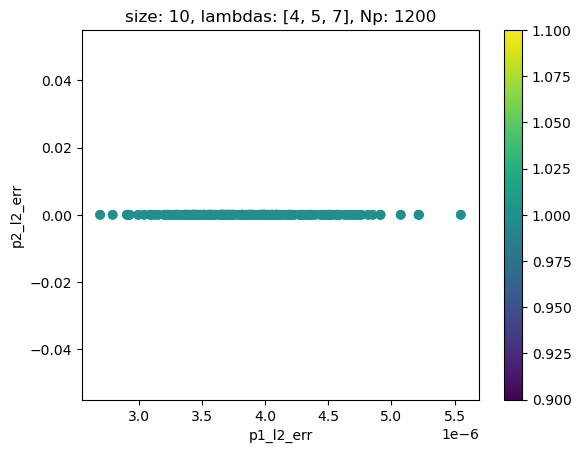

100%|██████████| 1/1 [00:07<00:00,  7.96s/it]


In [14]:
size = 15
speed = 1
n_envs = 1
lambdas = [3,4,5,7] #[3,4,5, 7] 
Np = 600
thresh = 2.0
c = 1 #0.60     # connection probability

results_dict = {}

for size in tqdm([10]):
    for lambdas in [[4,5,7]]:
        for Np in [1200]:
            for observation_size in [256]:

                print(f"size: {size}, lambdas: {lambdas}, Np: {Np}")

                pbook, pbook_flattened, gbook, gbook_flattened, Wpg, Wgp, module_sizes, module_gbooks, Npos, Ng = setup_scaffold(Np, lambdas, thresh, c)
                envs = [WMEnv(size=size, speed=speed, observation_size=observation_size, seed=int(rng.integers(0, 10_000_000))) for _ in range(n_envs)]
                path_sbook, path_pbook, path_gbook, Wsp, Wps = setup_envs(envs, size, n_envs, Npos, Ng, pbook, gbook)
                g_error, p1_l2_err, p2_l2_err,traversal = test_vectorhash(pbook, gbook, path_sbook, path_pbook, path_gbook, Wps, Wgp, Wpg, Wsp, thresh, lambdas)

                results_dict[(size, tuple(lambdas), Np)] = (p1_l2_err, p2_l2_err, g_error)

                print("Num patterns: ", path_sbook.shape[1])
                print("G error: ", np.average(g_error))

                plt.scatter(p1_l2_err, p2_l2_err, c=g_error, cmap='viridis')
                plt.xlabel("p1_l2_err")
                plt.ylabel("p2_l2_err")
                plt.title(f"size: {size}, lambdas: {lambdas}, Np: {Np}")
                plt.colorbar()
                plt.show()

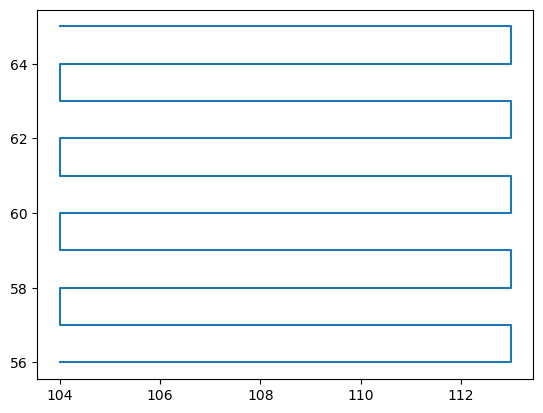

In [22]:
plt.plot(traversal[:100,0, 0], traversal[:100,0, 1])

In [1]:
# Initialize a pool of environments with fixed goals per env
seed = 1
size = 10
speed = 1
num_envs = 1
rng = np.random.RandomState(seed)
env_pool = []
Np = 1000
lambdas = [11,12,13]
input_type = "g"
observation_size = 512

vectorhash = VectorHash(Np=Np, lambdas=lambdas, size=size)

for i in range(num_envs):
    env_i = GridWMEnv(size=size, speed=speed, seed=int(rng.randint(0, 10_000_000)), observation_size=observation_size, input_type=input_type, start_type="corner")
    env_pool.append(env_i)

vectorhash.initiate_vectorhash(env_pool)
env = env_pool[0]
gbook = vectorhash.gbook
path_sbook = vectorhash.path_sbook

NameError: name 'np' is not defined

In [203]:
# traverse
vectorhash.Npos

np.int64(140)

In [82]:
print(env.current_location)
env.step((1, 0))
print(env.current_location)


(0, 0)
(1, 0)


In [ ]:
env.step((0, 1))

In [149]:
g_error, p1_l2_err, p2_l2_err,traversal = vectorhash.test_vectorhash()

In [150]:
np.average(g_error)

np.float64(1.0)

In [146]:
obs, s, p, g = env.obs()
matches = np.all(np.isclose(gbook, g[:, None, None], rtol=1e-6, atol=1e-8), axis=0)
idxs = np.argwhere(matches)
print(idxs)
print(env.current_location)

[[112  32]]
(0, 0)


In [147]:
print(traversal[0])
print(traversal[1])

[[113  37]]
[[117  34]]


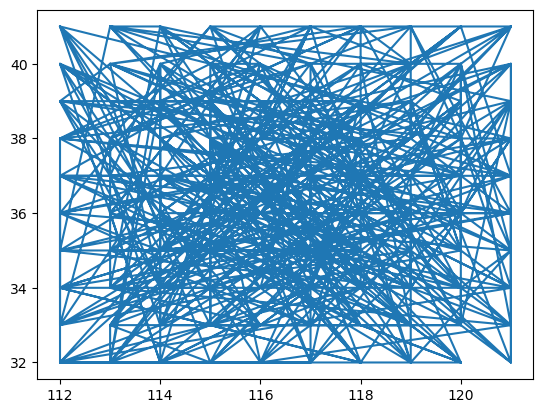

In [152]:
plt.plot(traversal[0:400,0, 0], traversal[0:400,0, 1])

In [171]:
import numpy as np
x = np.random.randint(0, size)
y = np.random.randint(0, size)
pos = (x, y)
for x in range(size):
    for y in range(size):
        for heading in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
            pos = (x, y)
            env._pos = pos
            env._heading = heading
            obs, s, p, g = env.obs()
            matches = np.all(np.isclose(gbook, g[:, None, None], rtol=1e-6, atol=1e-8), axis=0)
            idxs = np.argwhere(matches)
            print(idxs)
            print(pos)
pos = (0, 0)
print(pos)
env._pos = pos
env._heading = (1, 0)
obs, s, p, g = env.obs()
matches = np.all(np.isclose(gbook, g[:, None, None], rtol=1e-6, atol=1e-8), axis=0)
idxs = np.argwhere(matches)
print(idxs)


[[50 70]]
(0, 0)
[[50 70]]
(0, 0)
[[50 70]]
(0, 0)
[[50 70]]
(0, 0)
[[50 71]]
(0, 1)
[[50 71]]
(0, 1)
[[50 71]]
(0, 1)
[[50 71]]
(0, 1)
[[50 72]]
(0, 2)
[[50 72]]
(0, 2)
[[50 72]]
(0, 2)
[[50 72]]
(0, 2)
[[50 73]]
(0, 3)
[[50 73]]
(0, 3)
[[50 73]]
(0, 3)
[[50 73]]
(0, 3)
[[50 74]]
(0, 4)
[[50 74]]
(0, 4)
[[50 74]]
(0, 4)
[[50 74]]
(0, 4)
[[50 75]]
(0, 5)
[[50 75]]
(0, 5)
[[50 75]]
(0, 5)
[[50 75]]
(0, 5)
[[50 76]]
(0, 6)
[[50 76]]
(0, 6)
[[50 76]]
(0, 6)
[[50 76]]
(0, 6)
[[50 77]]
(0, 7)
[[50 77]]
(0, 7)
[[50 77]]
(0, 7)
[[50 77]]
(0, 7)
[[50 78]]
(0, 8)
[[50 78]]
(0, 8)
[[50 78]]
(0, 8)
[[50 78]]
(0, 8)
[[50 79]]
(0, 9)
[[50 79]]
(0, 9)
[[50 79]]
(0, 9)
[[50 79]]
(0, 9)
[[51 70]]
(1, 0)
[[51 70]]
(1, 0)
[[51 70]]
(1, 0)
[[51 70]]
(1, 0)
[[51 71]]
(1, 1)
[[51 71]]
(1, 1)
[[51 71]]
(1, 1)
[[51 71]]
(1, 1)
[[51 72]]
(1, 2)
[[51 72]]
(1, 2)
[[51 72]]
(1, 2)
[[51 72]]
(1, 2)
[[51 73]]
(1, 3)
[[51 73]]
(1, 3)
[[51 73]]
(1, 3)
[[51 73]]
(1, 3)
[[51 74]]
(1, 4)
[[51 74]]
(1, 4)
[[51 74]]
(1, 

In [13]:
obs, s, p, g = env.obs()
matches = np.all(np.isclose(gbook, g[:, None, None], rtol=1e-6, atol=1e-8), axis=0)
idxs = np.argwhere(matches)
print(idxs)
print(env.current_location)
print(env.heading)
print(env.grid_onehot_to_indices(g))

env.step((0, 1))
obs, s, p, g = env.obs()
matches = np.all(np.isclose(gbook, g[:, None, None], rtol=1e-6, atol=1e-8), axis=0)
idxs = np.argwhere(matches)
print(idxs)
print(env.current_location)
print(env.heading)
print(env.grid_onehot_to_indices(g))

# env.step((0, 1))
# obs, s, p, g = env.obs()
# matches = np.all(np.isclose(gbook, g[:, None, None], rtol=1e-6, atol=1e-8), axis=0)
# idxs = np.argwhere(matches)
# print(idxs)
# print(env.current_location)
# print(env.heading)

# env.step((0, 1))
# obs, s, p, g = env.obs()
# matches = np.all(np.isclose(gbook, g[:, None, None], rtol=1e-6, atol=1e-8), axis=0)
# idxs = np.argwhere(matches)
# print(idxs)
# print(env.current_location)


[[38 63]]
(0, 4)
(0, 1)


AttributeError: 'GridWMEnv' object has no attribute 'grid_onehot_to_indices'

In [ ]:
print(env.current_location.)